In [ ]:
# pip install matplotlib numpy pandas pmdarima seaborn scikit-learn statsmodels

In [376]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns 
import itertools

import pmdarima as pm

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams
from sklearn.ensemble import IsolationForest

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [377]:
df_train = pd.read_csv('./data/anonymized_train_data.csv')
df_test = pd.read_csv('./data/test_sheet_to_fill.csv')

In [378]:
lookup_model = {
    'CHINA':'sarimax',
    'Switzerland':'arima',
    'Ireland':'sarimax',
    'Germany':'arima',
    'USA':'sarimax'
}

lookup_sommthening = {
    'CHINA':'exponential',
    'Switzerland':'rolling',
    'Ireland':'exponential',
    'Germany':'exponential',
    'USA':'exponential'
}

In [379]:
count_a_vals = df_train['AP Adj'].values
diffs_a = count_a_vals[:-1] - count_a_vals[1:]
count_b_vals = df_train['Cost'].values
diffs_b = count_b_vals[:-1] - count_b_vals[1:]

df_train = df_train.iloc[1:].copy().reset_index()

df_train['cash_flow'] = np.array(diffs_a)
df_train['net_cost'] = np.array(diffs_b)

df_train = df_train[['Country', 'Date', 'cash_flow', 'net_cost']]

df_train.set_index(pd.DatetimeIndex(df_train['Date']),inplace = True)

In [380]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[:-1]

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [381]:
def outlier_smoothing(X, contamination=0.15, smoothing_window=4, plot=True, random_state=22, verbose=False):
    """
    Outlier identification by IForest and 
    smoothing by rolling window median value
    """

    X_rolling_median = X.rolling(smoothing_window).median()
    X_rolling_mean = X.rolling(smoothing_window).mean()
    X_smoothing_ratio = X / X_rolling_median

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_rolling_median, label='rolling median')
        plt.title("Original vs. Rolling Median")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,10))
        plt.plot(X.index, X_smoothing_ratio, label="original:smoothing ratio")
        plt.title("Smoothing Ratio")
        plt.legend()
        plt.show()
    
    ## Find the outliers
    iso_forest = IsolationForest(contamination=contamination,\
        random_state=random_state)
    peaks = np.where(iso_forest.fit_predict(X_smoothing_ratio[smoothing_window-1:].\
        values.reshape(-1,1))<1)
    if verbose:
        print("Outliers found at ", X.index[peaks[0]+smoothing_window-1])
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index.values[peaks[0]+smoothing_window-1],\
            X.values[peaks[0]+smoothing_window-1], 'x'
            )
        plt.title("Outlier Finders")
        plt.legend()
        plt.show()
    ## Change the outliers with corresponding smoothed values    
    X_smoothed = X.copy()

    for i in range(len(X)):
        if np.any(peaks[0]+smoothing_window-1==i):
            X_smoothed[i] = X_rolling_mean[i]

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_smoothed, label='smoothed')
        plt.title("Original vs. smoothed")
        plt.legend()
        plt.show()
    
    return X_smoothed

def smooth(full_data,plot=True):
    
    for i in full_data.columns:
        full_data[i] = outlier_smoothing(full_data[i].dropna(), plot=False) 
    return full_data

In [382]:
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [383]:
def best_parameters_sarimax(series, exog=None):
    '''
    Finds the best parameters for a given series for SARIMAX algorithm.
    Input: series: the series for which the parameters are to be determined.
            exog: extra features to be considered, here price increase related
    Output: the best parameters for the series and model.
    '''
    result_param = -1
    result_param_seasonal = -1
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
#                 print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                try:
                    if results.aic < minimum:
                        result_param = param
                        result_param_seasonal = param_seasonal
                except:
                    result_param = param
                    result_param_seasonal = param_seasonal
                    minimum = results.aic
            except:
                continue
    return result_param, result_param_seasonal

In [384]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [385]:
def data_smoothening(df_train,lookup,country):
    if lookup[country] == 'rolling':
        df_train = smooth(df_train,plot=False)
    else:
        df_train.cash_flow = double_exponential_smoothing(df_train.cash_flow, 1.0, 0.05)
    return df_train

In [386]:
def model_training(df_train,lookup,country):
    if lookup[country] == 'arima':
        auto_arima_fit = pm.auto_arima(df_train, start_p=1, start_q=1,
                                     max_p=3, max_q=3, m=12,
                                     start_P=0, seasonal=True,
                                     d=1, D=1, trace=False,
                                     error_action='ignore',
                                     suppress_warnings=True,
                                     stepwise=True)
        
        mod = ARIMA(df_train,order=auto_arima_fit.order)
        model = mod.fit()

    elif lookup[country] == 'sarimax':
        best_param, best_param_seasonal = best_parameters_sarimax(df_train, exog=None)
        mod = sm.tsa.statespace.SARIMAX(df_train,
                                    exog=None,
                                    order=best_param,
                                    seasonal_order=best_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
        model = mod.fit()
    return model

In [388]:
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
import os
if not os.path.exists('models'):
    os.makedirs('models')

CHINA


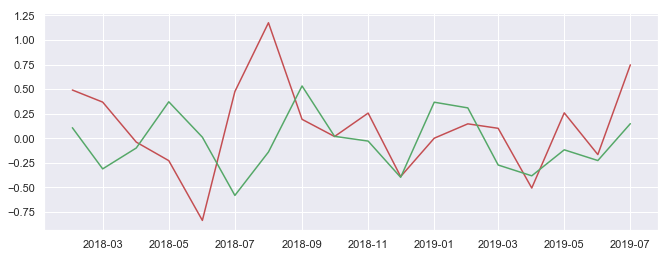


Germany


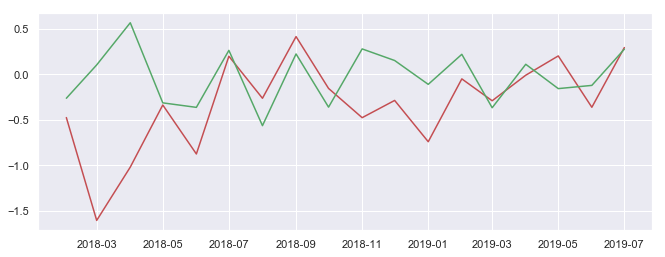


Ireland


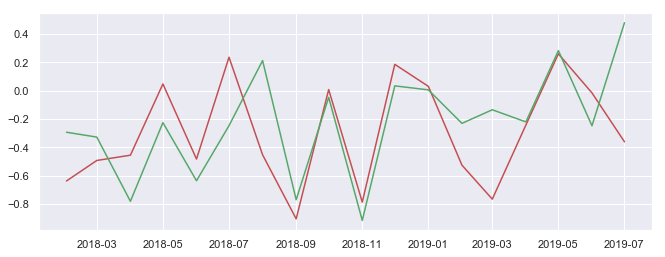


Switzerland


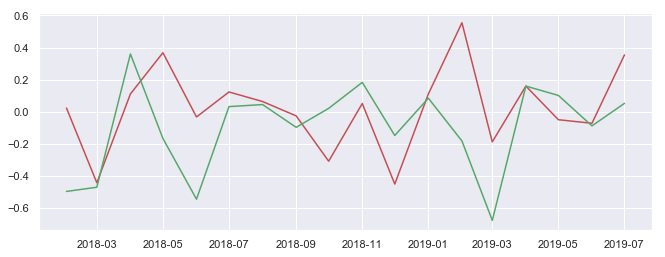


USA


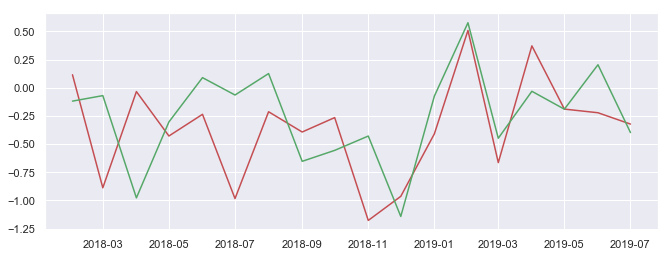

In [389]:
# training & cross validation
countries = df_train.Country.unique().tolist()
for country in countries:
    print(country)
    data = df_train[df_train.Country==country]
    data = data[['cash_flow']]
    data = data_smoothening(data,lookup_sommthening,country)
    model =  model_training(data,lookup_model,country)
    save_path = 'models/%s'%country
    save_obj(model, save_path)
    plt.figure()
    plt.plot(data.cash_flow[-18:],color='r')
    plt.plot(model.predict('2018-02-01','2019-07-01'),color='g')
    plt.show()
    print()

In [390]:
# prediction
def predict_forecasts(country,lookup,forecast_period = 5):
    save_path = 'models/%s'%country
    model = load_obj(save_path)
    if lookup[country] == 'arima':
        forecasts = model.forecast(5)[0].tolist()
    elif lookup[country] == 'sarimax':
        forecasts = model.get_forecast(steps=forecast_period)
        forecasts = forecasts.predicted_mean.tolist()
    return forecasts

In [391]:
forecast_period = 5
df =[]
for country in df_test.Country.unique().tolist():
    forecasts = predict_forecasts(country,lookup_model,forecast_period)
    temp = pd.DataFrame()
    temp['Country'] = [country] * forecast_period
    temp['Date'] = pd.date_range(start='2019/08/01', periods=forecast_period, freq='MS')
    temp['Cash Flow'] = forecasts
    df.append(temp)
submission = pd.concat(df)

In [392]:
submission.reset_index(inplace=True)
submission = submission[['Country', 'Date', 'Cash Flow']]

In [396]:
submission.to_csv('./data/test_sheet.csv', index=False)

CHINA


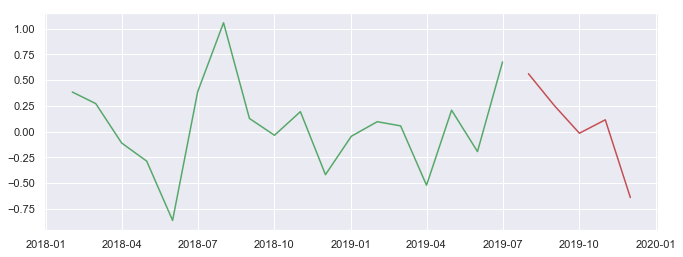

Germany


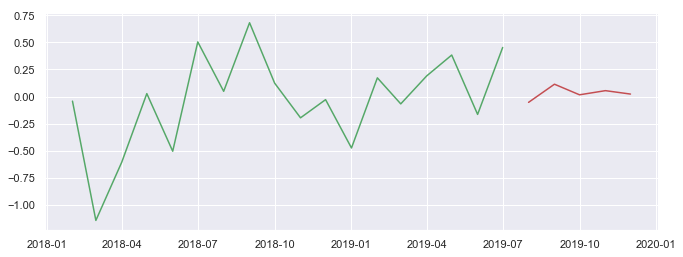

Ireland


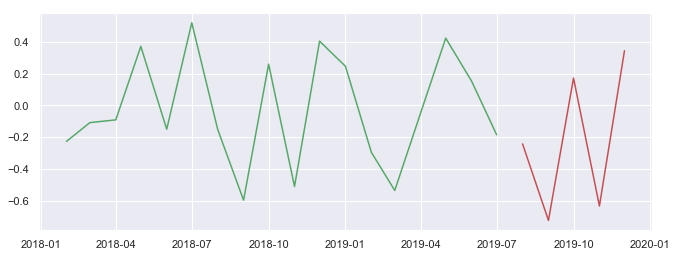

Switzerland


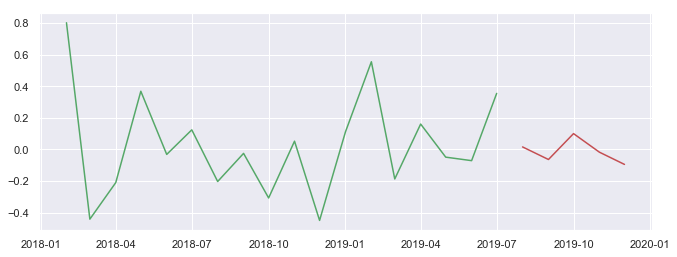

USA


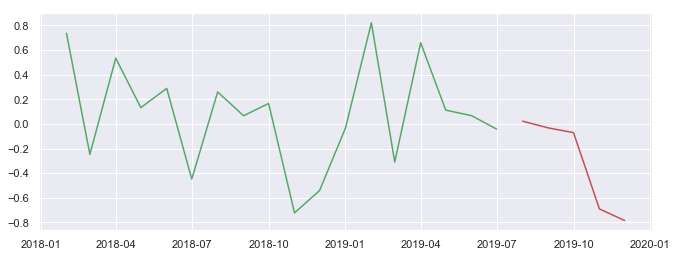

In [394]:
for country in df_test.Country.unique().tolist():
    print(country)
    submission.index = submission['Date']
    plt.plot(df_train[df_train.Country==country].cash_flow[-18:],color='g')
    plt.plot(submission[submission.Country==country]['Cash Flow'],color='r')
    plt.show()